# Build Datasets
Due to the limitation of dataset size, here i will create a new similar dataset from public dataset that can be found in [bhanupratapbiswas/fashion-products](https://www.kaggle.com/datasets/bhanupratapbiswas/fashion-products).

# Import Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Re-factor Datasets

## Load Original Data

In [34]:
df_data = pd.read_csv(f'../datasets/fashion/fashion_products.csv')
print(df_data.shape)
df_data.head()

(1000, 9)


,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


In [35]:
print('Total Product:', len(df_data['Product Name'].unique()))
print('Total Brand:', len(df_data['Brand'].unique()))
print('Total Category:', len(df_data['Category'].unique()))

Total Product: 5
Total Brand: 5
Total Category: 3


## Simplify Product Catalog
Due to the large variety of products, we will simplify the product catalog that ignore the color and size. We will assume the price is the same as the average of any color and size.

In [36]:
df_catalog = df_data.drop(columns=['User ID', 'Product ID', 'Rating']).drop_duplicates()
df_catalog = df_catalog.groupby(by=['Product Name', 'Brand', 'Category']).agg({'Price': 'mean'}).reset_index()
df_catalog

,Product Name,Brand,Category,Price
0,Dress,Adidas,Kids' Fashion,53.916667
1,Dress,Adidas,Men's Fashion,44.500000
2,Dress,Adidas,Women's Fashion,47.666667
3,Dress,Gucci,Kids' Fashion,50.200000
4,Dress,Gucci,Men's Fashion,51.125000
...,...,...,...,...
70,T-shirt,Nike,Men's Fashion,56.500000
71,T-shirt,Nike,Women's Fashion,72.166667
72,T-shirt,Zara,Kids' Fashion,65.750000
73,T-shirt,Zara,Men's Fashion,52.818182


## Assing Product ID
We will assign new product ID according to this number of product variations

In [37]:
df_catalog = df_catalog.reset_index(names=['Product ID'])
df_catalog

,Product ID,Product Name,Brand,Category,Price
0,0,Dress,Adidas,Kids' Fashion,53.916667
1,1,Dress,Adidas,Men's Fashion,44.500000
2,2,Dress,Adidas,Women's Fashion,47.666667
3,3,Dress,Gucci,Kids' Fashion,50.200000
4,4,Dress,Gucci,Men's Fashion,51.125000
...,...,...,...,...,...
70,70,T-shirt,Nike,Men's Fashion,56.500000
71,71,T-shirt,Nike,Women's Fashion,72.166667
72,72,T-shirt,Zara,Kids' Fashion,65.750000
73,73,T-shirt,Zara,Men's Fashion,52.818182


## Build Dataset
This will be our dataset and will be normalize as the same as the given one

In [38]:
df_dataset = pd.merge(
    left=df_data[['User ID', 'Product Name', 'Brand', 'Category', 'Rating']],
    right=df_catalog,
    on=['Product Name', 'Brand', 'Category'],
)
df_dataset

,User ID,Product Name,Brand,Category,Rating,Product ID,Price
0,19,Dress,Adidas,Men's Fashion,1.043159,1,44.500000
1,97,Shoes,H&M,Women's Fashion,4.026416,38,69.636364
2,25,Dress,Adidas,Women's Fashion,3.337938,2,47.666667
3,57,Shoes,Zara,Men's Fashion,1.049523,43,55.388889
4,79,T-shirt,Adidas,Men's Fashion,4.302773,61,58.294118
...,...,...,...,...,...,...,...
995,20,Shoes,Zara,Women's Fashion,1.620081,44,49.466667
996,42,Sweater,Nike,Kids' Fashion,1.544464,54,49.100000
997,9,Sweater,Zara,Men's Fashion,3.961913,58,48.250000
998,8,T-shirt,Zara,Women's Fashion,3.089722,74,67.375000


# Interaction Dataset
Because this public dataset does not have the number of `page_view` and `time_spent`, so we will generate the values based on given characteristics

## Original Dataset Statistic

In [39]:
df_interaction = pd.read_csv('../datasets/original/customer_interactions.csv')
df_interaction

,customer_id,page_views,time_spent
0,1,25,120
1,2,20,90
2,3,30,150
3,4,15,80
4,5,22,110


In [40]:
df_history = pd.read_csv('../datasets/original/purchase_history.csv', sep=';')
df_history = df_history.loc[:, ~df_history.columns.str.contains('^Unnamed')]
df_history

,customer_id,product_id,purchase_date
0,1,101,2023-01-01
1,1,105,2023-01-05
2,2,102,2023-01-02
3,3,103,2023-01-03
4,4,104,2023-01-04
5,5,101,2023-01-05


In [41]:
df_user_purchase = df_history.groupby(by=['customer_id']).agg({'product_id': 'count'}).reset_index().rename(columns={'product_id': 'purchased_items'})

df_stat = pd.merge(
    left=df_interaction,
    right=df_user_purchase,
    on=['customer_id'],
)
df_stat

,customer_id,page_views,time_spent,purchased_items
0,1,25,120,2
1,2,20,90,1
2,3,30,150,1
3,4,15,80,1
4,5,22,110,1


In [42]:
df_stat['views_per_purchase'] = df_stat['page_views'] / df_stat['purchased_items']
df_stat['views_per_purchase'].describe()

count     5.00000
mean     19.90000
std       6.80441
min      12.50000
25%      15.00000
50%      20.00000
75%      22.00000
max      30.00000
Name: views_per_purchase, dtype: float64

In [43]:
df_stat['time_per_purchase'] = df_stat['time_spent'] / df_stat['purchased_items']
df_stat['time_per_purchase'].describe()

count      5.000000
mean      98.000000
std       34.205263
min       60.000000
25%       80.000000
50%       90.000000
75%      110.000000
max      150.000000
Name: time_per_purchase, dtype: float64

## Build Synthetic Dataset

In [44]:
df_interaction = df_dataset.groupby(
    by=['User ID']
).agg({'Product ID': 'count'}).reset_index().rename(columns={
    'User ID': 'customer_id',
    'Product ID': 'purchased_items',
})
df_interaction

,customer_id,purchased_items
0,1,9
1,2,9
2,3,11
3,4,12
4,5,8
...,...,...
95,96,6
96,97,9
97,98,14
98,99,8


In [53]:
def clip_value(val, val_min, val_max):
    return max(val_min, val)
    # return max(val_min, min(val_max, val))

def synthetic_value(n, mean_std_min_max, clip=False):
    mean, std, min_, max_ = mean_std_min_max
    val = n * np.random.normal(mean, std)
    if clip:
        return clip_value(val, min_, max_)
    return val


df_interaction['page_views'] = df_interaction['purchased_items'].apply(
    lambda n: synthetic_value(n, df_stat['views_per_purchase'].agg(['mean', 'std', 'min', 'max']).values, clip=True)
)
df_interaction['time_spent'] = df_interaction['purchased_items'].apply(
    lambda n: synthetic_value(n, df_stat['time_per_purchase'].agg(['mean', 'std', 'min', 'max']).values, clip=True)
)
df_interaction.drop(columns=['purchased_items']).to_csv('../datasets/fashion/customer_interactions.csv', index=False)
df_interaction

,customer_id,purchased_items,page_views,time_spent
0,1,9,338.235511,787.564590
1,2,9,176.947044,509.615888
2,3,11,167.598075,1044.910471
3,4,12,288.084280,1630.702851
4,5,8,241.019015,1259.073957
...,...,...,...,...
95,96,6,116.190077,347.969710
96,97,9,229.204006,588.974559
97,98,14,202.383143,1015.626165
98,99,8,137.690688,916.866165


## Synthetic Dataset Statistic

In [46]:
df_stat2 = df_interaction.copy()
df_stat2['views_per_purchase'] = df_stat2['page_views'] / df_stat2['purchased_items']
df_stat2['views_per_purchase'].describe()

count    100.000000
mean      20.388263
std        6.793908
min        1.388889
25%       17.143742
50%       20.868312
75%       25.135804
max       35.389042
Name: views_per_purchase, dtype: float64

In [47]:
df_stat2['time_per_purchase'] = df_stat2['time_spent'] / df_stat2['purchased_items']
df_stat2['time_per_purchase'].describe()

count    100.000000
mean      92.218474
std       33.192354
min       17.744883
25%       70.789775
50%       88.533270
75%      111.595094
max      187.355566
Name: time_per_purchase, dtype: float64

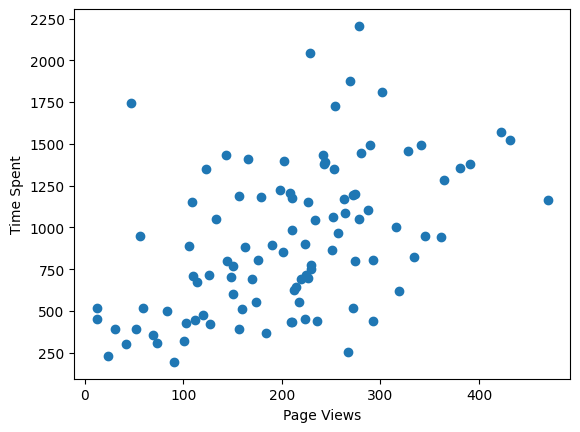

In [48]:
plt.scatter(df_interaction['page_views'], df_interaction['time_spent'])
plt.xlabel('Page Views')
plt.ylabel('Time Spent')
plt.show()

# Product Details

In [49]:
df_dataset.head()

,User ID,Product Name,Brand,Category,Rating,Product ID,Price
0,19,Dress,Adidas,Men's Fashion,1.043159,1,44.500000
1,97,Shoes,H&M,Women's Fashion,4.026416,38,69.636364
2,25,Dress,Adidas,Women's Fashion,3.337938,2,47.666667
3,57,Shoes,Zara,Men's Fashion,1.049523,43,55.388889
4,79,T-shirt,Adidas,Men's Fashion,4.302773,61,58.294118


In [56]:
df_product = df_dataset.groupby(
    by=['Product Name', 'Brand', 'Category', 'Product ID']
).agg({
    'Rating': 'mean', 
    'Price': 'mean'
}).reset_index()
df_product = df_product.rename(columns={
    'Product ID': 'product_id',
})
df_product = df_product.rename(columns={
    'Product Name': 'category',
    'Rating': 'ratings',
    'Price': 'price',
    'Brand': 'brand',
    'Category': 'kind',
})
df_product.sort_values(by=['product_id'])
df_product = df_product[['product_id', 'ratings', 'price', 'category', 'brand', 'kind']]
df_product.to_csv('../datasets/fashion/product_details.csv', sep=';', index=False)
df_product

,product_id,ratings,price,category,brand,kind
0,0,3.270463,53.916667,Dress,Adidas,Kids' Fashion
1,1,2.879264,44.500000,Dress,Adidas,Men's Fashion
2,2,2.673620,47.666667,Dress,Adidas,Women's Fashion
3,3,3.689981,50.200000,Dress,Gucci,Kids' Fashion
4,4,3.282323,51.125000,Dress,Gucci,Men's Fashion
...,...,...,...,...,...,...
70,70,2.436425,56.500000,T-shirt,Nike,Men's Fashion
71,71,2.636504,72.166667,T-shirt,Nike,Women's Fashion
72,72,3.548573,65.750000,T-shirt,Zara,Kids' Fashion
73,73,2.520955,52.818182,T-shirt,Zara,Men's Fashion


# Purchase History

In [52]:
df_history = df_dataset[['User ID', 'Product ID']].rename(columns={'User ID': 'customer_id', 'Product ID': 'product_id'})
df_history['purchase_date'] = None
df_history.to_csv('../datasets/fashion/purchase_history.csv', sep=';', index=False)
df_history

,customer_id,product_id,purchase_date
0,19,1,None
1,97,38,None
2,25,2,None
3,57,43,None
4,79,61,None
...,...,...,...
995,20,44,None
996,42,54,None
997,9,58,None
998,8,74,None


In [54]:
df_interaction

,customer_id,purchased_items,page_views,time_spent
0,1,9,338.235511,787.564590
1,2,9,176.947044,509.615888
2,3,11,167.598075,1044.910471
3,4,12,288.084280,1630.702851
4,5,8,241.019015,1259.073957
...,...,...,...,...
95,96,6,116.190077,347.969710
96,97,9,229.204006,588.974559
97,98,14,202.383143,1015.626165
98,99,8,137.690688,916.866165
